In [1]:
#import pandas as pd
import numpy as np
#import copy

#from typing import Tuple

import matplotlib.pyplot as plt

#import json

from icecream import ic

#import pickle

#from statsmodels.formula.api import ols
#from statsmodels.regression.linear_model import RegressionResultsWrapper

In [2]:
import sys
sys.path.insert(1, r'C:\\Users\\GHarr\\OneDrive - Lincoln College\\Python Projects\Data Science\\ghlibrary')

import dataframe_tools # type: ignore
from dag_tools import DirectedAcyclicGraph # type: ignore
from causal_tools import CausalModel # type: ignore
from misc_tools import calculate_percentage_accuracy # type: ignore

A complex DAG taken from 'Causal Inference in Statistics' that includes 5 colliders, 3 forks and a chain between the treatment and outcome 

Chains


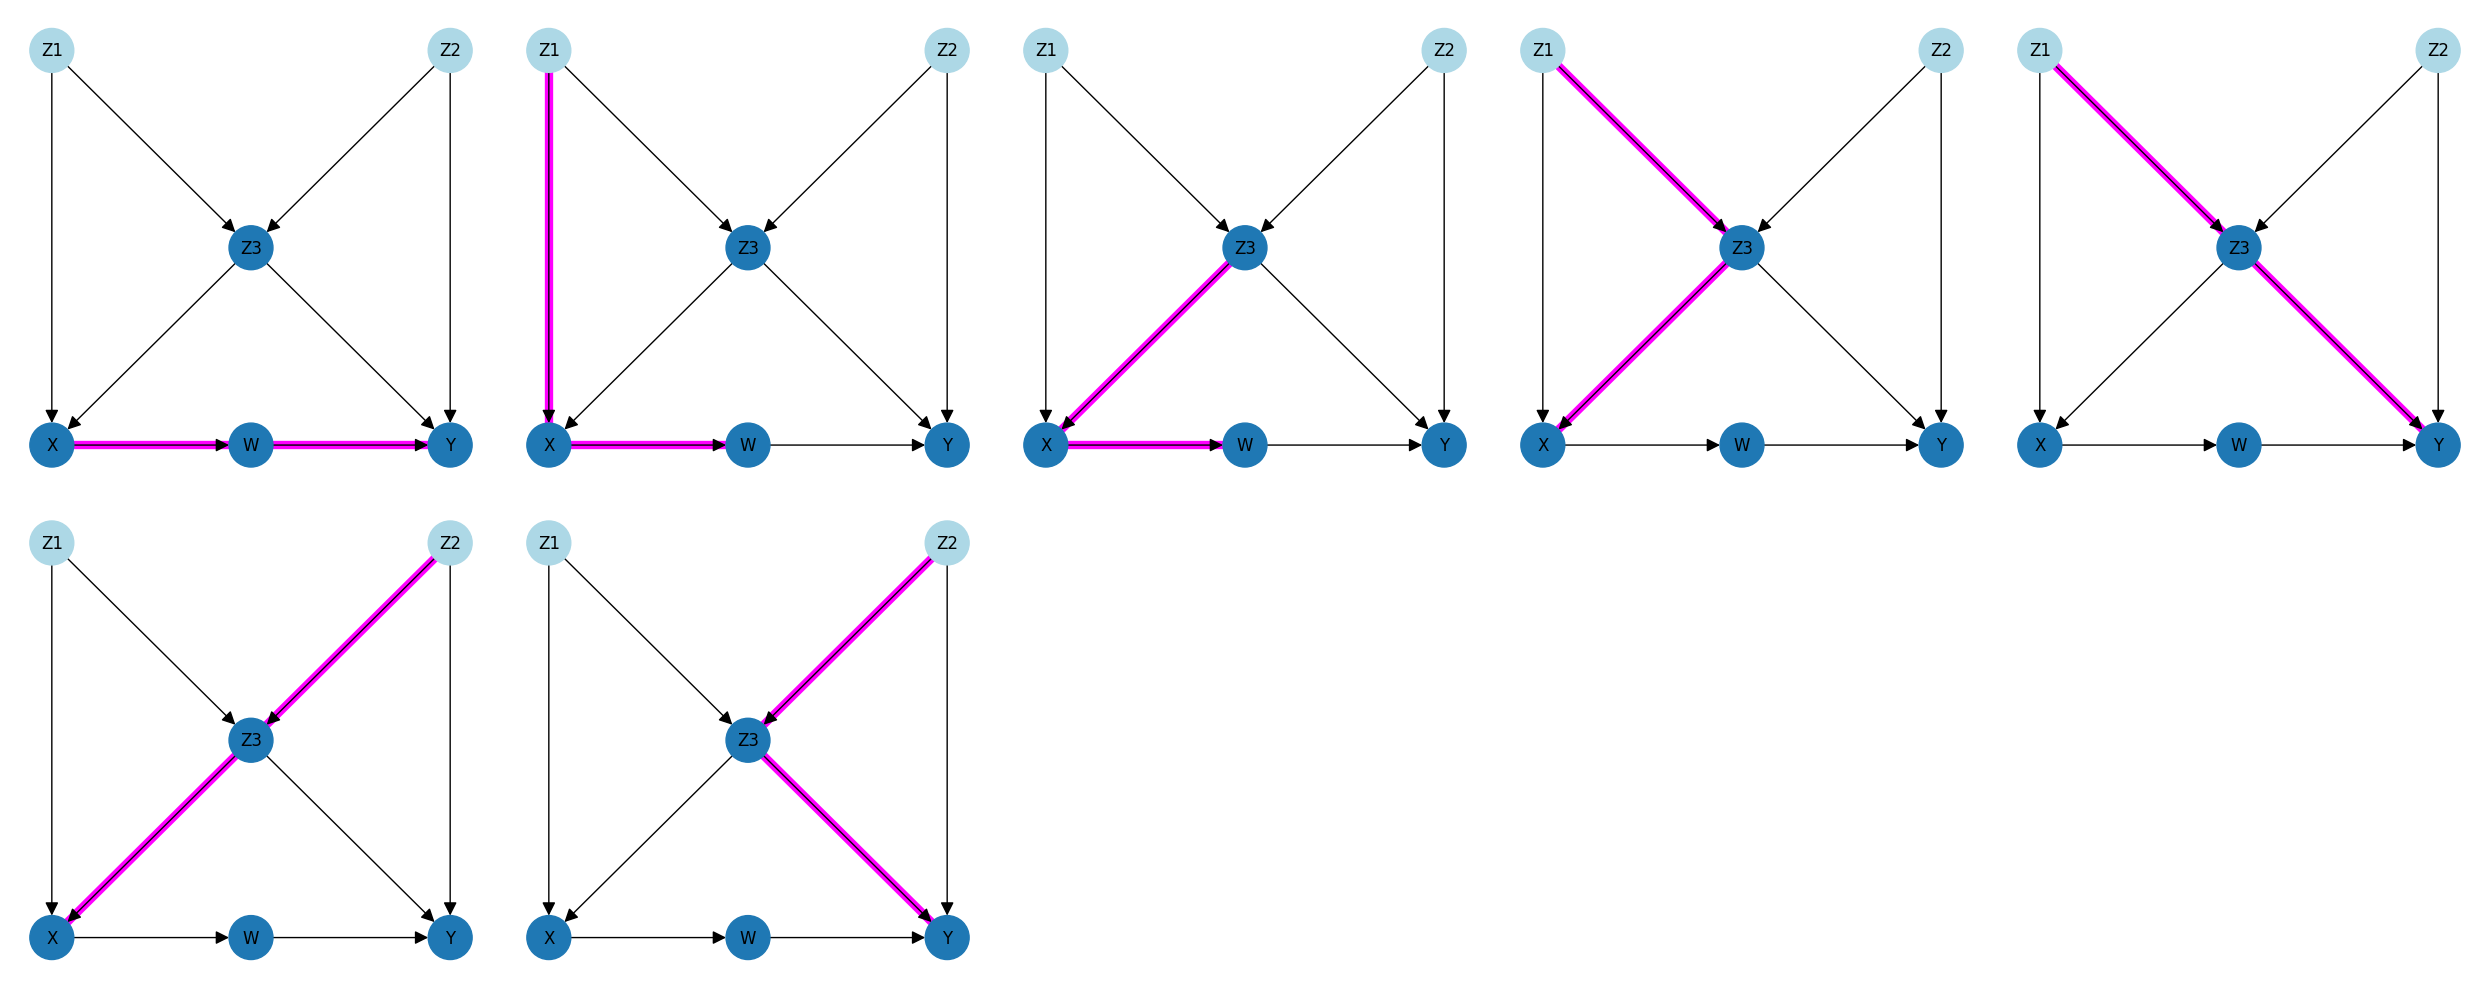

1) X -> W -> Y
2) Z1 -> X -> W
3) Z3 -> X -> W
4) Z1 -> Z3 -> X
5) Z1 -> Z3 -> Y
6) Z2 -> Z3 -> X
7) Z2 -> Z3 -> Y

Forks


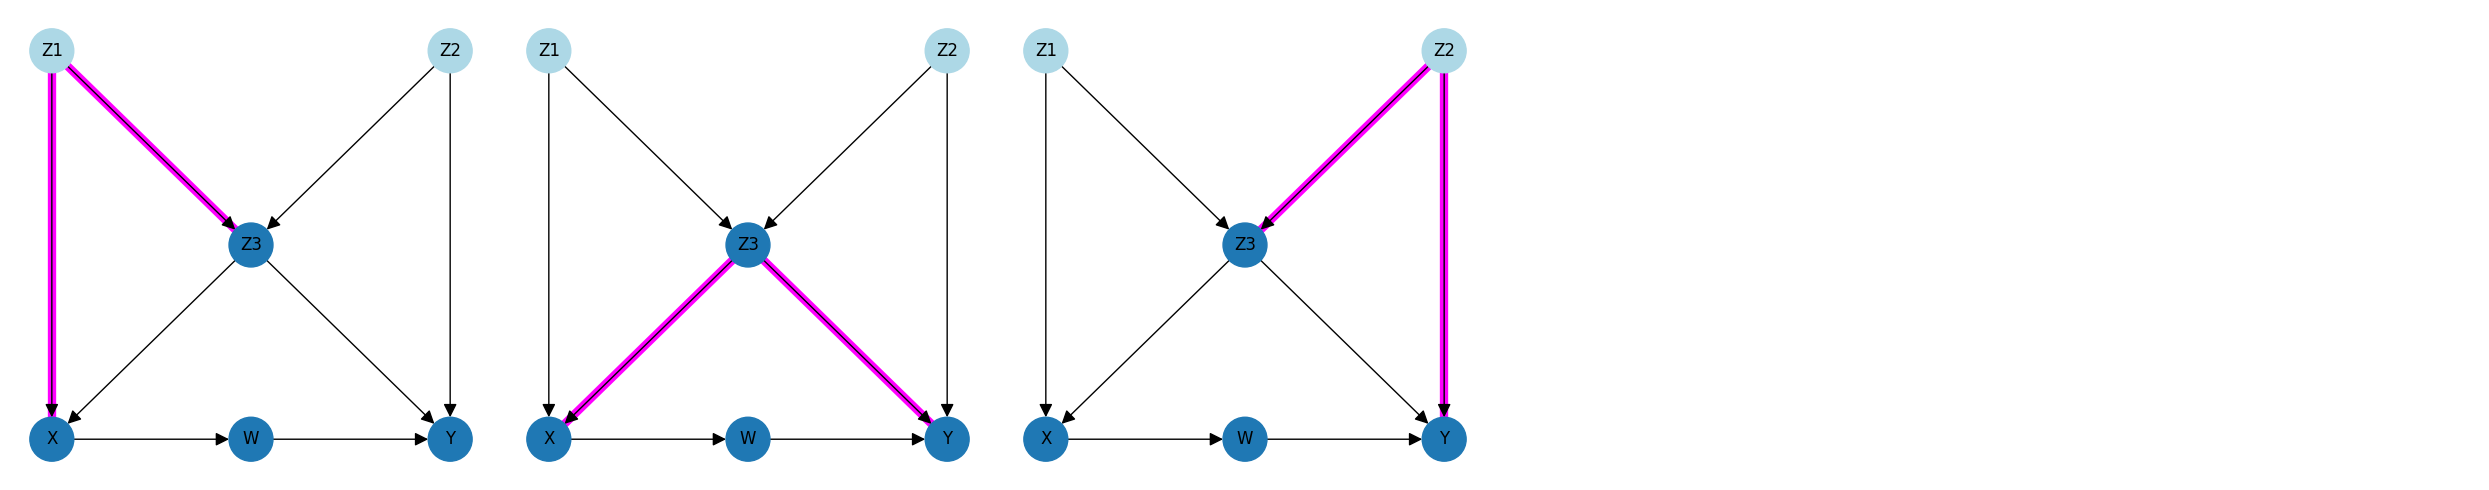

1) X <- Z1 -> Z3
2) X <- Z3 -> Y
3) Y <- Z2 -> Z3

Colliders


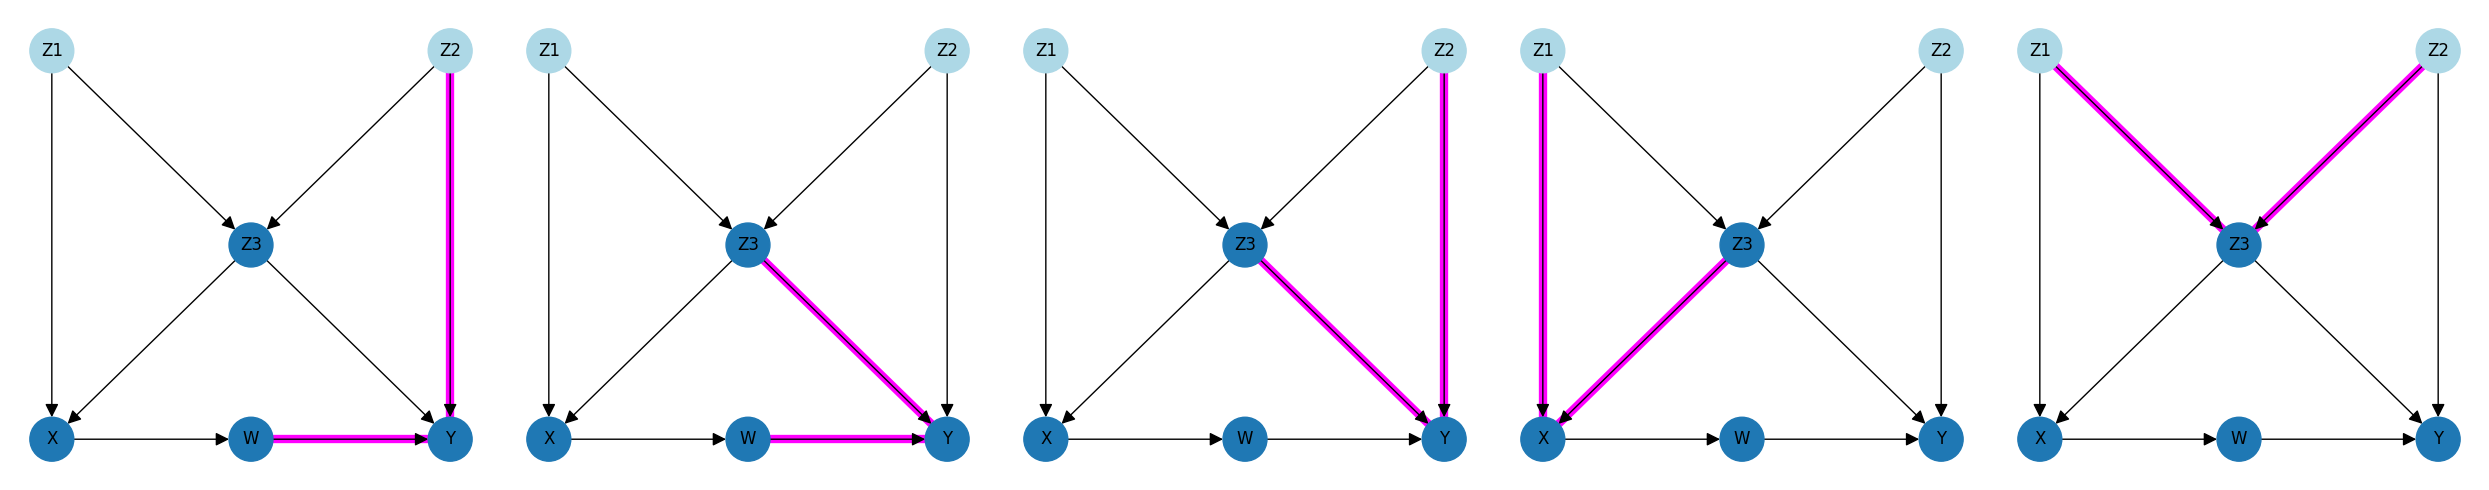

1) W -> Y <- Z2
2) W -> Y <- Z3
3) Z2 -> Y <- Z3
4) Z1 -> X <- Z3
5) Z1 -> Z3 <- Z2



In [3]:
example_dag = DirectedAcyclicGraph.example_dags()["causal_inference_in_statistics_1"]
print(example_dag["description"], "\n")

dag: DirectedAcyclicGraph = example_dag["dag"]
dag.draw_junctions(cols=5, print_paths=True)

In [4]:
random_seed = 100

def create_display_model(dag_name: str, display_results: bool = True) -> CausalModel:
    """Create and display a model frm the collection of example DAGs

    Args:
        dag_name (str): The name of the DAG in example dags

    Returns:
        CausalModel: A causal model built using the named example DAG containing fitted example data
    """
    # Extract the example DAG and draw it
    dag = DirectedAcyclicGraph.example_dags()[dag_name]["dag"]

    global random_seed
    random_seed+=1

    # Instantiate a causal model based on the named DAG and fit it with auto-generated test data
    causal_model = CausalModel(dag=dag, random_state=random_seed)
    causal_model.fit(X = None)

    if display_results:
        dag.draw(grid_size=5, labels=causal_model.edge_weightings)
        plt.show()

        display(causal_model.data)

        # Draw a 4-way scatter of the single junction represented by the DAG (as those chosen in this notebook are all single-junction DAGs)
        causal_model.scatter_junction(junction = dag.junctions[0])
        plt.show()

    return causal_model # Return the causal model

ic| 'CausalModel.fit'
ic| expr_str: 'Z = 2 x X + ε'
ic| expr_str: 'Y = -1.5 x Z + ε'


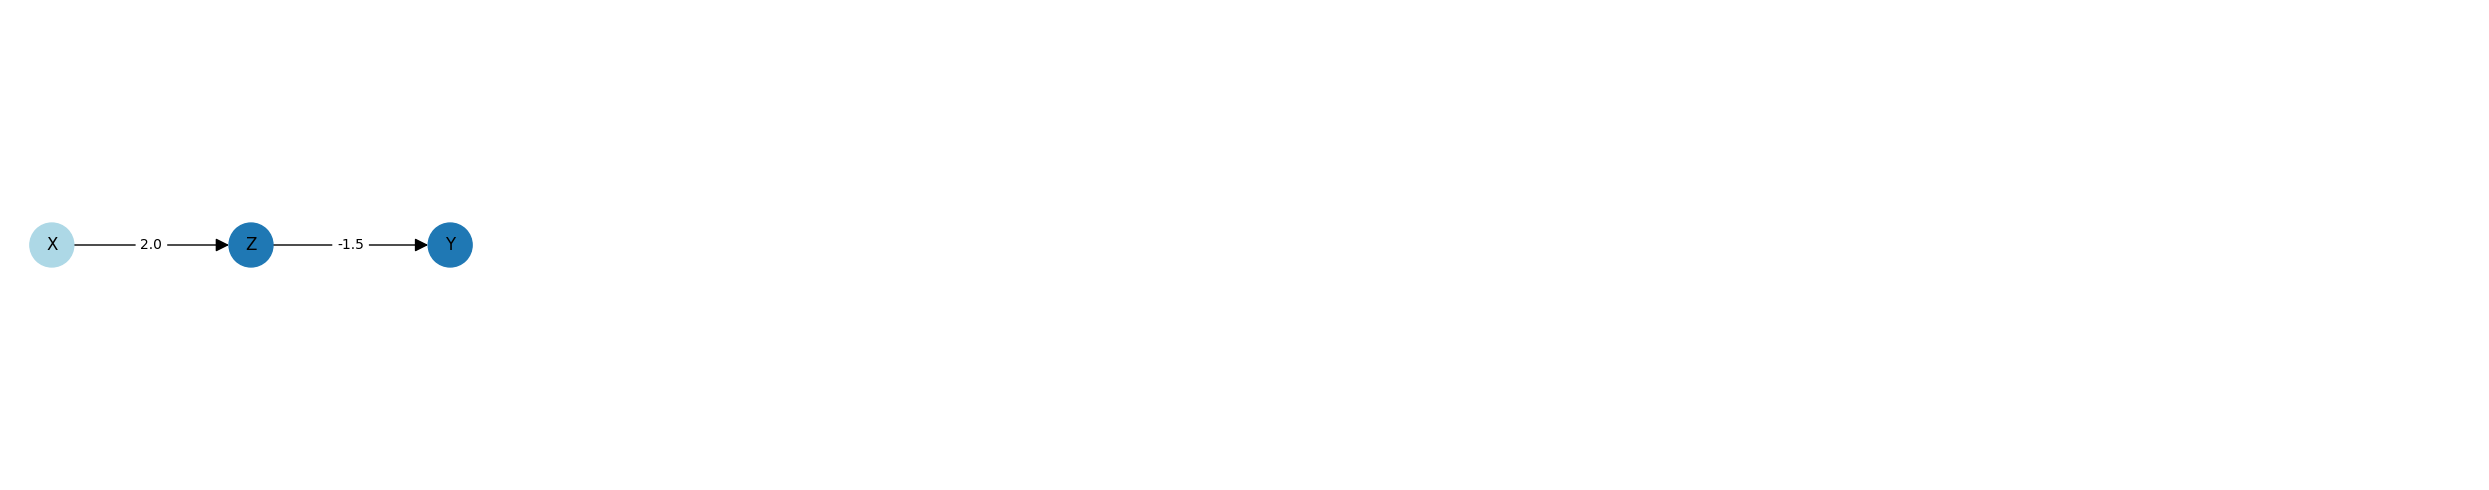

,X,Z,Y
0,7.073706,14.421021,-21.895914
1,6.438930,11.780809,-19.997919
2,6.670278,13.736251,-18.506942
3,5.146045,10.285976,-12.651194
4,4.315541,7.469024,-11.660516
...,...,...,...
995,5.959337,12.859272,-17.551811
996,6.662308,12.689145,-19.714022
997,5.080409,9.902116,-15.474873
998,6.671077,13.330932,-19.486743


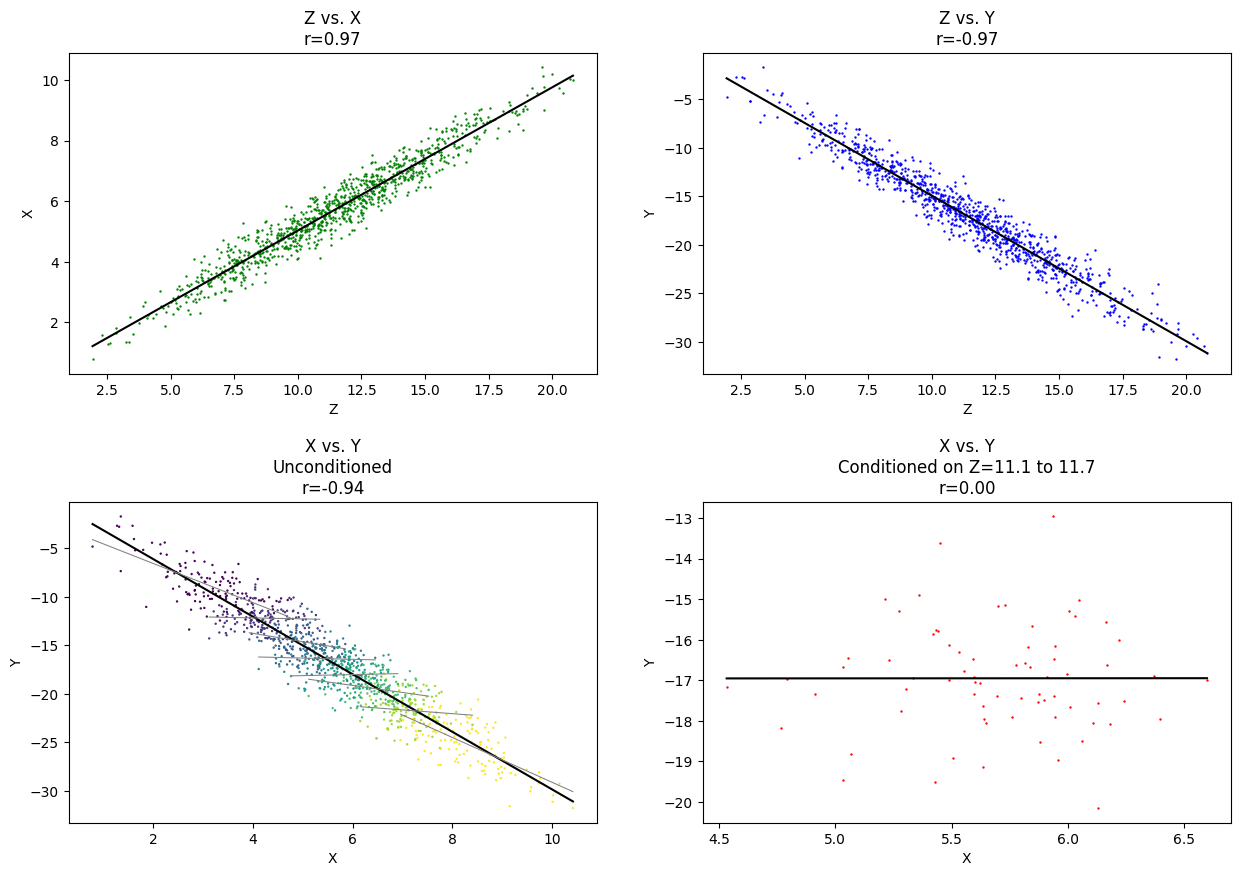

In [5]:
fork_causal_model = create_display_model("simple_chain")

In [6]:
fork_causal_model.structural_equations

{'X': 'X = np.random.normal(5.647587649322015, 1.5706675868681397)',
 'Z': 'Z = 2 x X + ε',
 'Y': 'Y = -1.5 x Z + ε'}

In [7]:
fork_causal_model.edge_weightings

{('X', 'Z'): 2.0, ('Z', 'Y'): -1.5}

In [8]:
for edge, edge_weighting in fork_causal_model.edge_weightings.items():
    print(edge, edge_weighting)


('X', 'Z') 2.0
('Z', 'Y') -1.5


ic| expression: 'Y ⫫̸ X'


Y ~ X


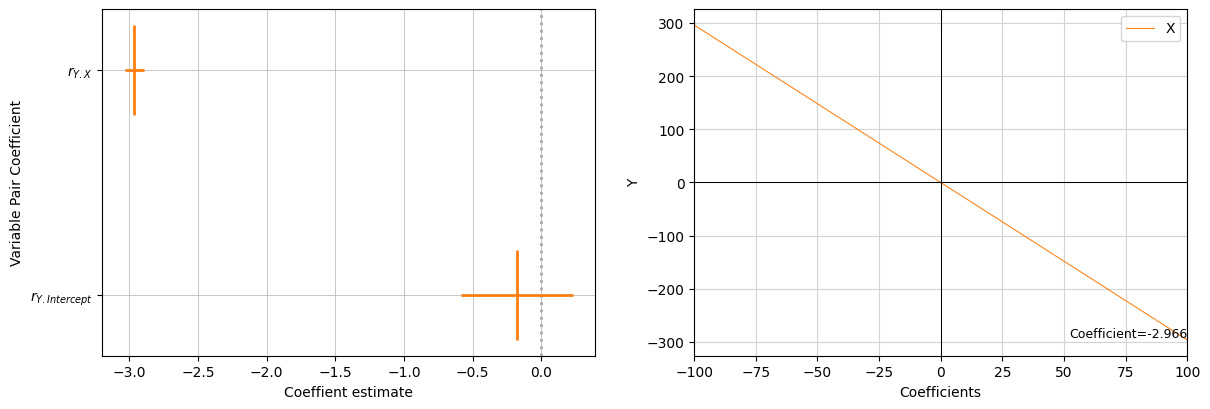

True


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     7129.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:49:35   Log-Likelihood:                -2022.9
No. Observations:                1000   AIC:                             4050.
Df Residuals:                     998   BIC:                             4060.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1767      0.208     -0.850      0.396      -0.585       0.231
X             -2.9658      0.035    -84.431      0.000      -3.035      -2.897
==============================================================================
Omnibus:                        5.860   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.952
Skew:                          -0.185   Prob(JB):                       0.0510
Kurtosis:                       2.919   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
is_dependent_on, errors, ols_results = fork_causal_model.data.dependence(expression="Y ⫫̸ X", show_charts=True)
print(is_dependent_on)
ols_results.summary()

In [10]:
r_zx = fork_causal_model.edge_weightings[("X", "Z")]
r_yz = fork_causal_model.edge_weightings[("Z", "Y")]
r_yx = r_zx * r_yz

ols_change = ols_results.params["X"]

accuracy = calculate_percentage_accuracy(ols_change, r_yx)

print(f"The calculated value is {accuracy:.2%} accurate")

The calculated value is 98.86% accurate


ic| expression: 'Y ⫫̸ X | Z'


Y ~ X + Z


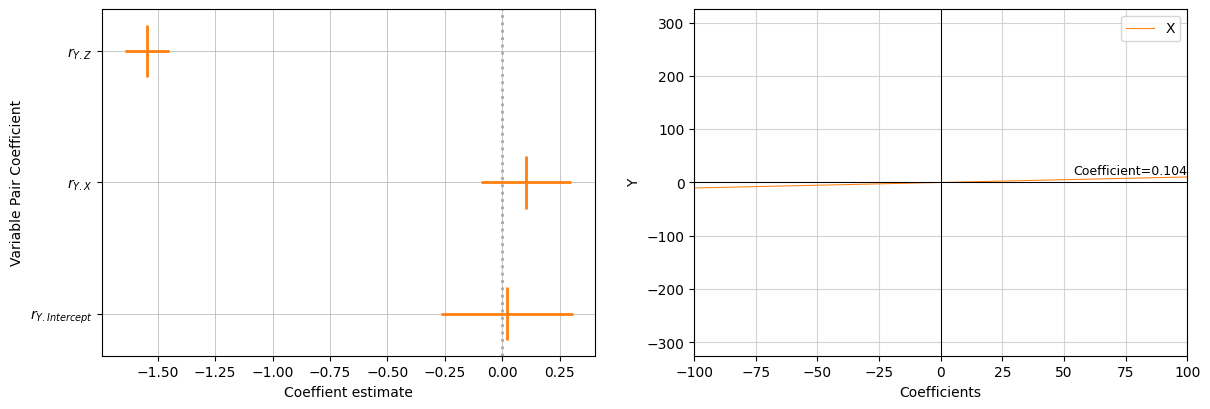

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     7669.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:49:35   Log-Likelihood:                -1673.3
No. Observations:                1000   AIC:                             3353.
Df Residuals:                     997   BIC:                             3367.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0205      0.147      0.140      0.889      -0.268       0.309
X              0.1035      0.100      1.038      0.300      -0.092       0.299
Z             -1.5482      0.049    -31.764      0.000      -1.644      -1.453
==============================================================================
Omnibus:                        0.665   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.717   Jarque-Bera (JB):                0.536
Skew:                           0.008   Prob(JB):                        0.765
Kurtosis:                       3.112   Cond. No.                         48.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
is_dependent_on, errors, ols_results = fork_causal_model.data.dependence(expression="Y ⫫̸ X | Z", show_charts=True, ylim=(-325, 325), exclude_conditionals=True)
print(is_dependent_on)
ols_results.summary()

In [12]:
ols_results.pvalues["X"]

0.2997275348495016

ic| 'CausalModel.fit'
ic| expr_str: 'X = -2.5 x Z + ε'
ic| expr_str: 'Y = -3 x Z + ε'


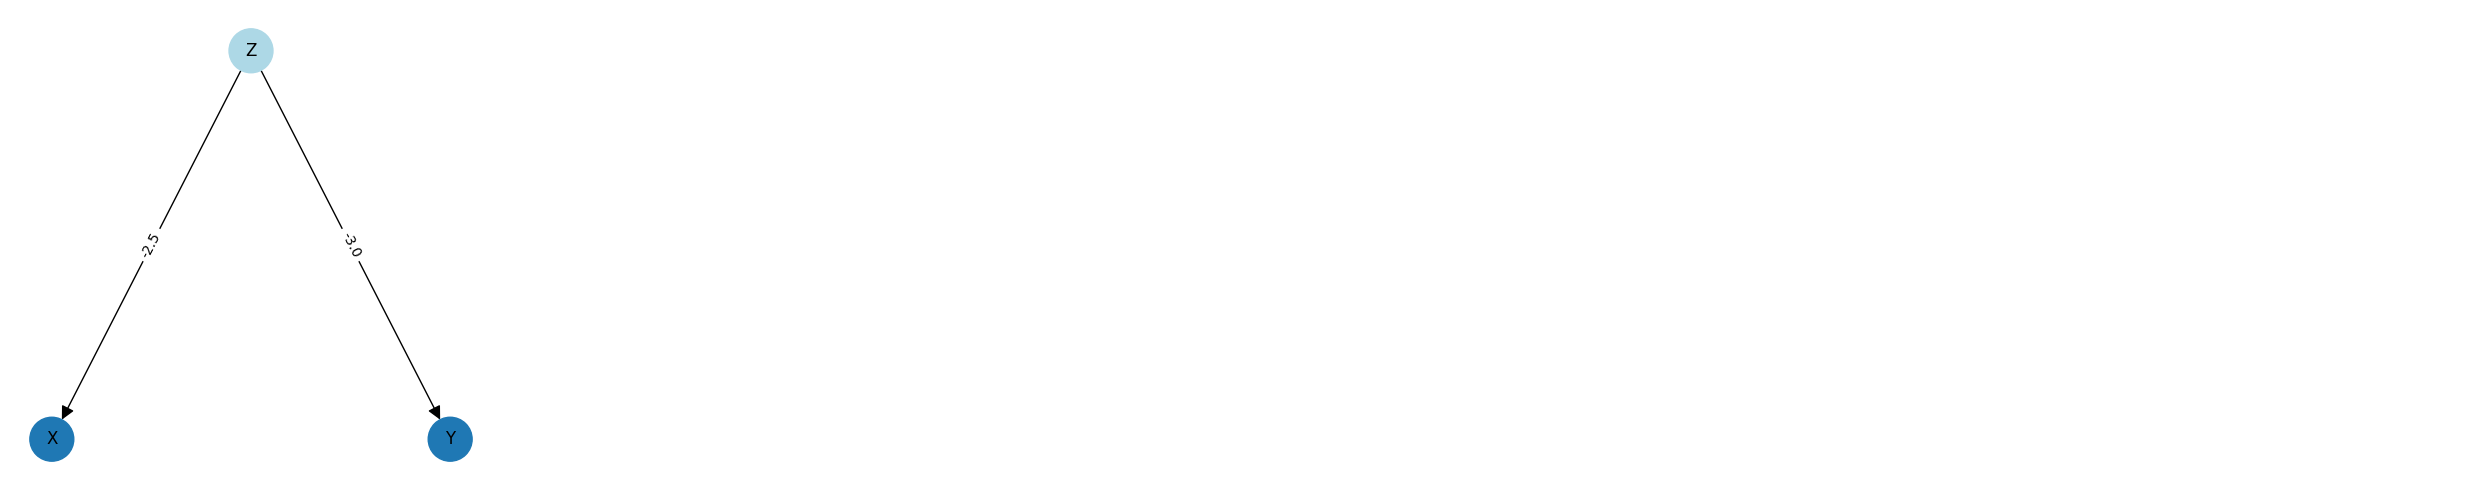

,Z,X,Y
0,8.152323,-21.969448,-24.417421
1,4.836658,-12.222028,-14.981507
2,8.557496,-20.631325,-25.728016
3,6.934193,-14.747129,-20.579592
4,5.524641,-13.221072,-15.837309
...,...,...,...
995,6.868654,-16.349010,-21.252302
996,4.503509,-11.098550,-12.610507
997,9.212545,-23.447524,-25.129828
998,7.111940,-18.023340,-20.362848


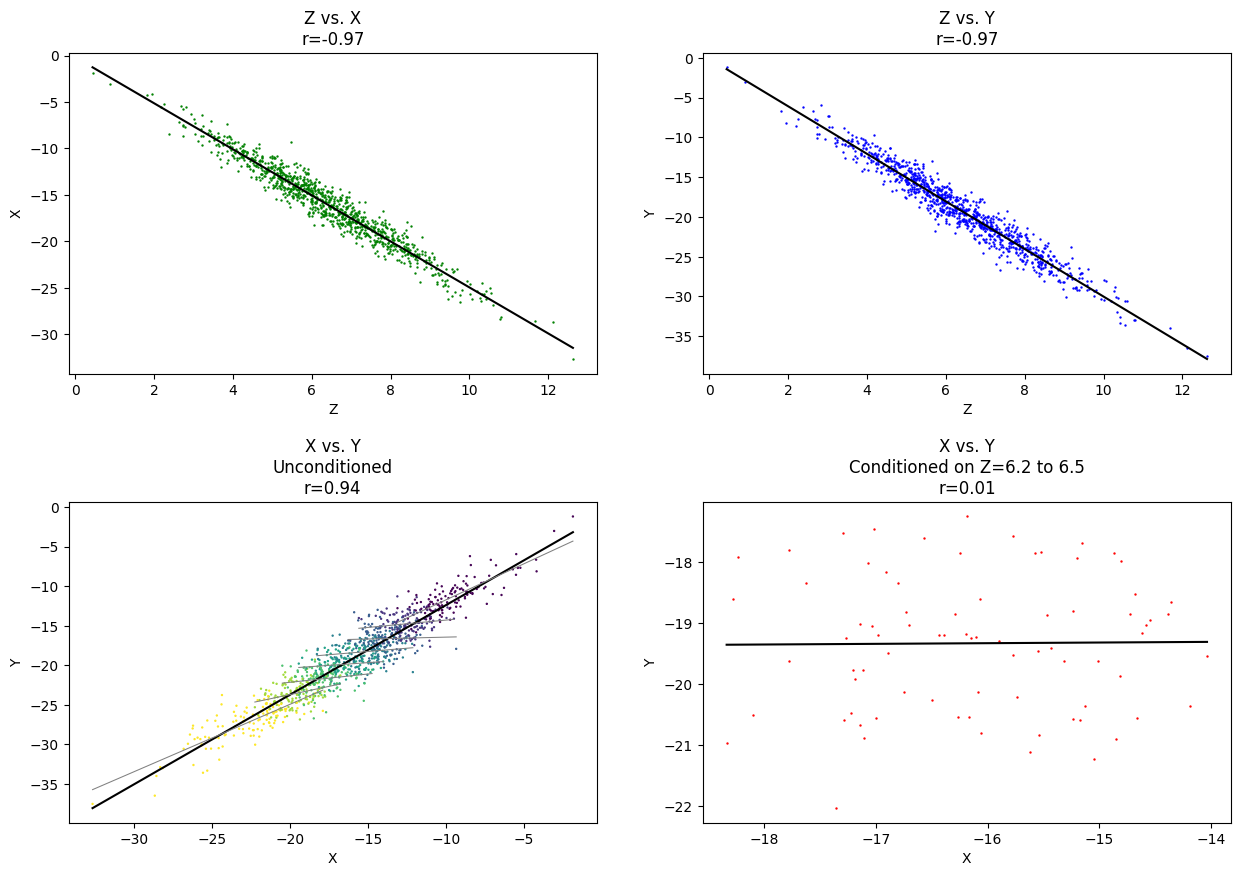

In [13]:
fork_causal_model = create_display_model("simple_fork")

In [14]:
fork_causal_model.structural_equations

{'Z': 'Z = np.random.normal(6.379134264424568, 1.6759869043722841)',
 'X': 'X = -2.5 x Z + ε',
 'Y': 'Y = -3 x Z + ε'}

ic| expression: 'Y ⫫̸ X'


Y ~ X


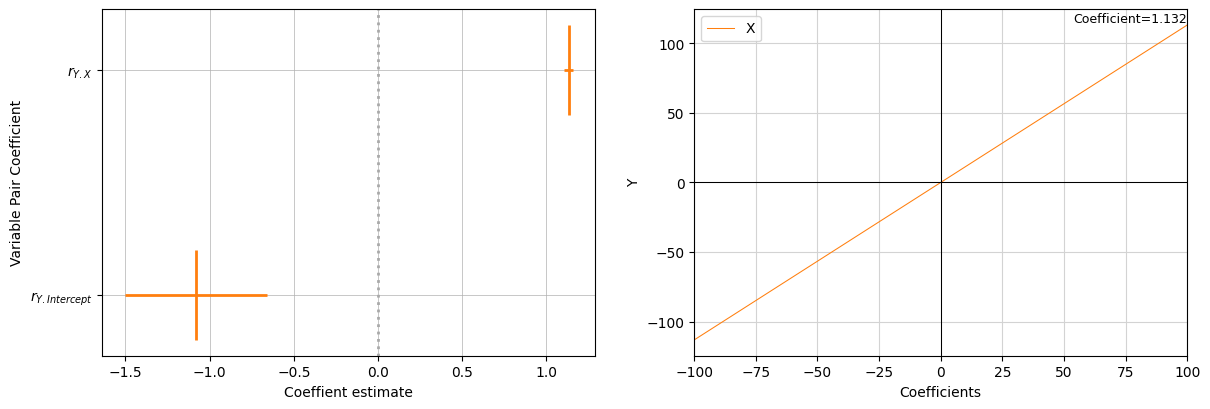

True


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     7521.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:49:36   Log-Likelihood:                -1969.6
No. Observations:                1000   AIC:                             3943.
Df Residuals:                     998   BIC:                             3953.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.0806      0.216     -5.005      0.000      -1.504      -0.657
X              1.1321      0.013     86.725      0.000       1.106       1.158
==============================================================================
Omnibus:                        1.803   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.788
Skew:                          -0.003   Prob(JB):                        0.409
Kurtosis:                       3.207   Cond. No.                         65.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
is_dependent_on, errors, ols_results = fork_causal_model.data.dependence(expression="Y ⫫̸ X", show_charts=True)
print(is_dependent_on)
ols_results.summary()

ic| expression: 'Y ⫫̸ X | Z'


Y ~ X + Z


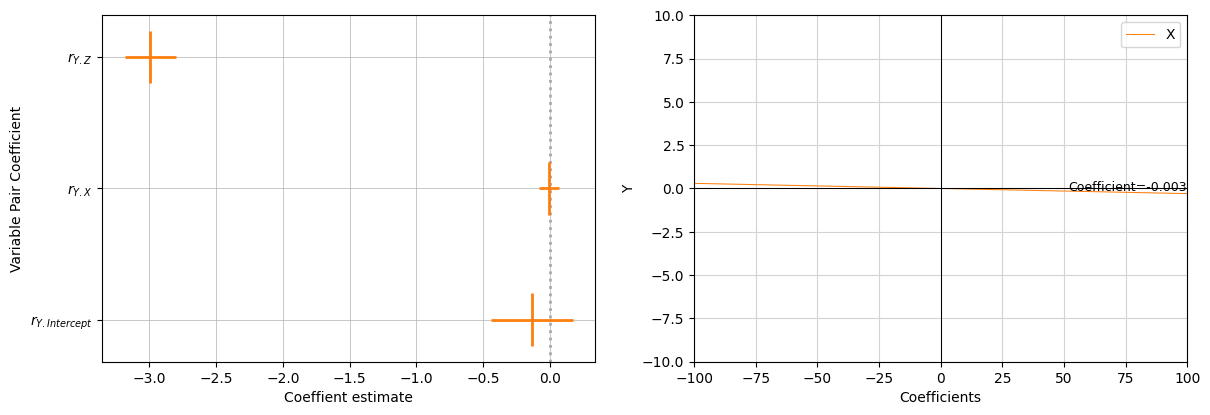

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     7813.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):               0.00
Time:                        08:49:36   Log-Likelihood:                -1634.9
No. Observations:                1000   AIC:                             3276.
Df Residuals:                     997   BIC:                             3290.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1331      0.158     -0.844      0.399      -0.442       0.176
X             -0.0030      0.038     -0.078      0.938      -0.078       0.072
Z             -2.9949      0.097    -30.826      0.000      -3.186      -2.804
==============================================================================
Omnibus:                        4.516   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.393
Skew:                          -0.142   Prob(JB):                        0.111
Kurtosis:                       3.159   Cond. No.                         72.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
is_dependent_on, errors, ols_results = fork_causal_model.data.dependence(expression="Y ⫫̸ X | Z", show_charts=True, ylim=(-10, 10), exclude_conditionals=True)
print(is_dependent_on)
ols_results.summary()

ic| 'CausalModel.fit'
ic| expr_str: 'Z = 3 x X + 1.5 x Y + ε'


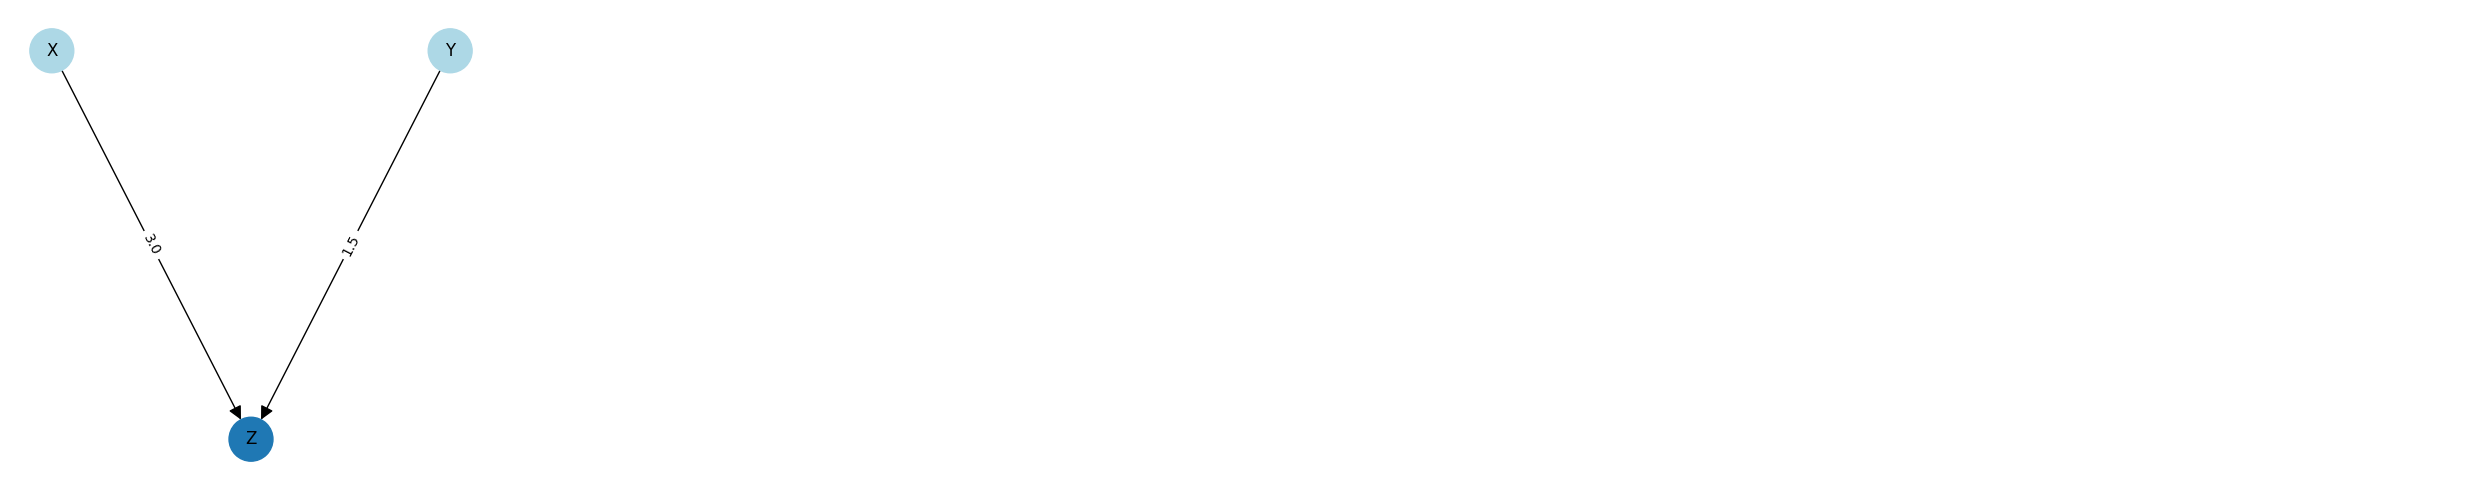

,X,Y,Z
0,5.339657,2.838914,21.699702
1,4.436386,4.209207,19.873020
2,3.614817,3.969693,16.604745
3,7.621657,2.334701,26.677919
4,5.394845,4.209831,22.699403
...,...,...,...
995,4.714531,5.520394,21.380471
996,6.112224,4.684789,25.868671
997,4.436417,3.379774,18.654721
998,3.839339,5.912388,18.680217


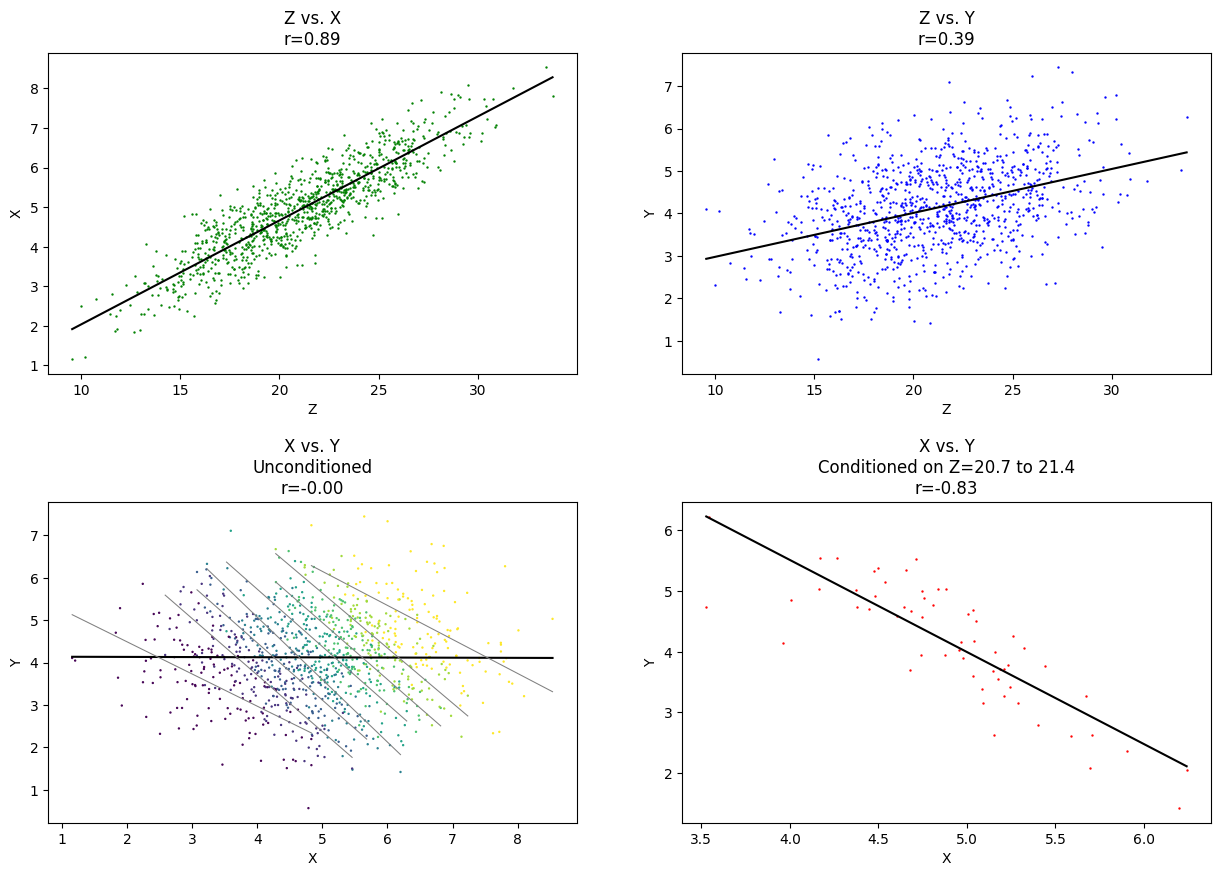

In [17]:
collider_causal_model = create_display_model("simple_collider")

ic| expression: 'Y ⫫̸ X'


Y ~ X


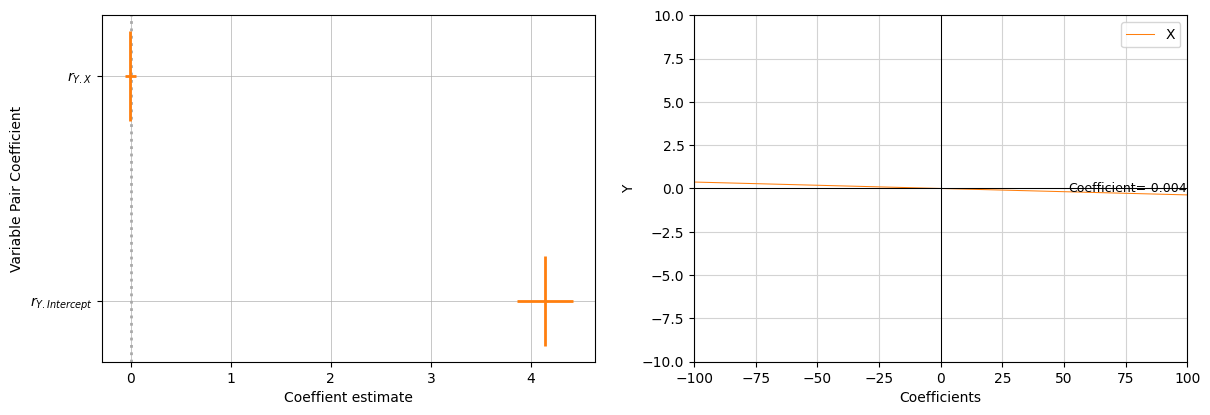

False


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01734
Date:                Tue, 19 Dec 2023   Prob (F-statistic):              0.895
Time:                        08:49:37   Log-Likelihood:                -1451.3
No. Observations:                1000   AIC:                             2907.
Df Residuals:                     998   BIC:                             2916.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1407      0.143     28.942      0.000       3.860       4.421
X             -0.0037      0.028     -0.132      0.895      -0.059       0.052
==============================================================================
Omnibus:                        0.045   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.029
Skew:                           0.013   Prob(JB):                        0.985
Kurtosis:                       3.001   Cond. No.                         23.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
is_dependent_on, errors, ols_results = collider_causal_model.data.dependence(expression="Y ⫫̸ X", show_charts=True, ylim=(-10, 10))
print(is_dependent_on)
ols_results.summary()

ic| expression: 'Y ⫫̸ X | Z'


Y ~ X + Z


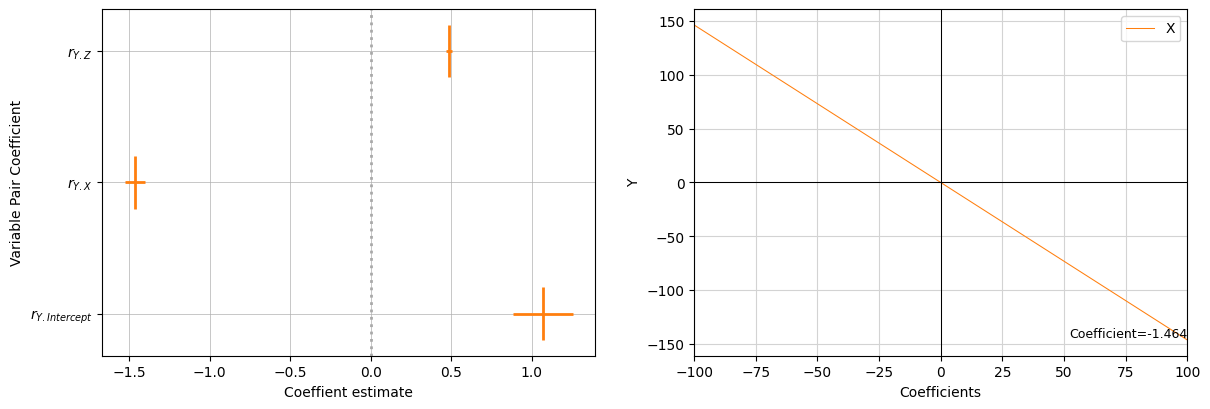

True


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1364.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          4.38e-286
Time:                        08:49:37   Log-Likelihood:                -792.23
No. Observations:                1000   AIC:                             1590.
Df Residuals:                     997   BIC:                             1605.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0706      0.095     11.323      0.000       0.885       1.256
X             -1.4643      0.032    -46.426      0.000      -1.526      -1.402
Z              0.4883      0.009     52.230      0.000       0.470       0.507
==============================================================================
Omnibus:                        0.560   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.570
Skew:                          -0.058   Prob(JB):                        0.752
Kurtosis:                       2.979   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
is_dependent_on, errors, ols_results = collider_causal_model.data.dependence(expression="Y ⫫̸ X | Z", show_charts=True, exclude_conditionals=True)
print(is_dependent_on)
ols_results.summary()

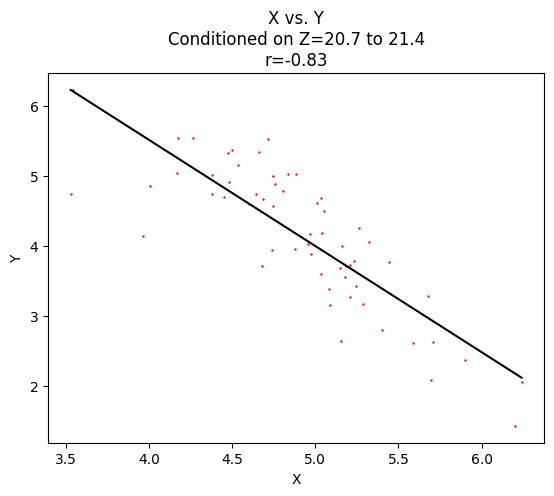

In [20]:
df_conditioned = collider_causal_model.data.scatter_conditioned(X="X", Y="Y", conditioned_on="Z")

In [24]:
import pandas as pd

In [25]:
pd.qcut(collider_causal_model.data["Z"], q=10, labels=False)

0      5
1      3
2      1
3      9
4      6
      ..
995    5
996    8
997    2
998    2
999    4
Name: Z, Length: 1000, dtype: int64

33.778683574482734

In [30]:
x = list(collider_causal_model.data["Z"].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]))
x

[16.11685867169433,
 17.60082093376219,
 18.833899025511926,
 19.922079418894718,
 21.098877201562402,
 22.084487849147294,
 23.155563162084313,
 24.59809468900303,
 26.17118137721673]

In [36]:
ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1364.
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          4.38e-286
Time:                        08:37:32   Log-Likelihood:                -792.23
No. Observations:                1000   AIC:                             1590.
Df Residuals:                     997   BIC:                             1605.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0706      0.095     11.323      0.000       0.885       1.256
X             -1.4643      0.032    -46.426      0.000      -1.526      -1.402
Z              0.4883      0.009     52.230      0.000       0.470       0.507
==============================================================================
Omnibus:                        0.560   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.756   Jarque-Bera (JB):                0.570
Skew:                          -0.058   Prob(JB):                        0.752
Kurtosis:                       2.979   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
ols_results.params["X"]

-1.4642644239470703

In [24]:
total = 0
X_mult = -3
divisor = 1.5
for index, row in df_conditioned.iterrows():

    total+= (row["Z"] + (X_mult * row["X"])) / divisor
    
print(total / index+1)

1.2488973947556115


In [ ]:
# Z = 3 x X + 1.5 x Y + 

In [35]:
3 * df_conditioned.loc[22, "X"] + 1.5 * df_conditioned.loc[22, "Y"]

21.989602174198502

In [38]:
df_conditioned["Z"].mean()

21.06290657039535

In [42]:
df_conditioned["Y"].mean()

4.125204767786311

In [41]:
((df_conditioned["Z"].mean()) - (3 * df_conditioned["X"].mean())) / 1.5

4.214381311200946

In [36]:
((df_conditioned.loc[34, "Z"]) - (3 * df_conditioned.loc[34, "X"])) / 1.5

5.347156623310483

In [34]:
df_conditioned["Z"].mean()

21.06290657039535

In [33]:
df_conditioned

,X,Y,Z
22,4.658881,5.341972,21.118050
25,5.148078,3.679727,21.286314
34,4.376492,5.009038,21.150212
37,5.085197,3.377897,21.392634
43,5.007614,4.611831,21.391986
128,3.541691,6.222858,20.878840
167,4.953625,4.025484,21.193889
186,4.681047,3.702579,20.836404
197,4.642835,4.735673,20.917597
216,4.537593,5.147951,21.281235


In [34]:
(df_conditioned["Y"] / df_conditioned["X"]).mean()

0.8691104398537419

In [20]:
def test_chain(n_tests: int = 100):
    ic.disable()
    chain_tests_passed = 0
    accuracies = []

    for _ in range(n_tests):
        chain_causal_model = create_display_model("simple_chain", display_results=False)

        is_dependent_on_conditioned, _, ols_results = chain_causal_model.data.dependence(expression="Y ⫫̸ X | Z")
        is_dependent_on_unconditioned, _, ols_results = chain_causal_model.data.dependence(expression="Y ⫫̸ X")

        if (is_dependent_on_unconditioned == True) and (is_dependent_on_conditioned == False):
            chain_tests_passed += 1
#        else:
#            print(chain_causal_model.structural_equations)

            r_zx = chain_causal_model.edge_weightings[("X", "Z")]
            r_yz = chain_causal_model.edge_weightings[("Z", "Y")]
            r_yx = r_zx * r_yz

            ols_change = ols_results.params["X"]

            accuracies.append(calculate_percentage_accuracy(ols_change, r_yx))

    print(f"Chain tests: {chain_tests_passed}/{n_tests} passed ({chain_tests_passed/n_tests:.1%})")
    print(f"The calculated effect of X on Y is {np.mean(np.array(accuracies)):.1%} accurate")

    ic.enable()

    return

In [21]:
test_chain(100)

Chain tests: 93/100 passed (93.0%)
The calculated effect of X on Y is 99.2% accurate


In [22]:
def test_fork(n_tests: int = 100):
    ic.disable()
    fork_tests_passed = 0
    accuracies = []

    for _ in range(n_tests):
        fork_causal_model = create_display_model("simple_fork", display_results=False)

        is_dependent_on_conditioned, _, ols_results = fork_causal_model.data.dependence(expression="Y ⫫̸ X | Z")
        is_dependent_on_unconditioned, _, ols_results = fork_causal_model.data.dependence(expression="Y ⫫̸ X")

        if (is_dependent_on_unconditioned == True) and (is_dependent_on_conditioned == False):
            fork_tests_passed += 1

            r_xz = fork_causal_model.edge_weightings[("Z", "X")]
            r_yz = fork_causal_model.edge_weightings[("Z", "Y")]
            
            r_yx = (1 / r_xz) * r_yz

            ols_change = ols_results.params["X"]

            accuracies.append(calculate_percentage_accuracy(ols_change, r_yx))

    print(f"Fork tests: {fork_tests_passed}/{n_tests} passed ({fork_tests_passed/n_tests:.1%})")
    print(f"The calculated effect of X on Y is {np.mean(np.array(accuracies)):.1%} accurate")

    ic.enable()

    return

In [23]:
test_fork(n_tests=100)

Fork tests: 92/100 passed (92.0%)
The calculated effect of X on Y is 94.3% accurate


ic| 'CausalModel.fit'
ic| expr_str: 'Z = -2.5 x X + -1.5 x Y + ε'


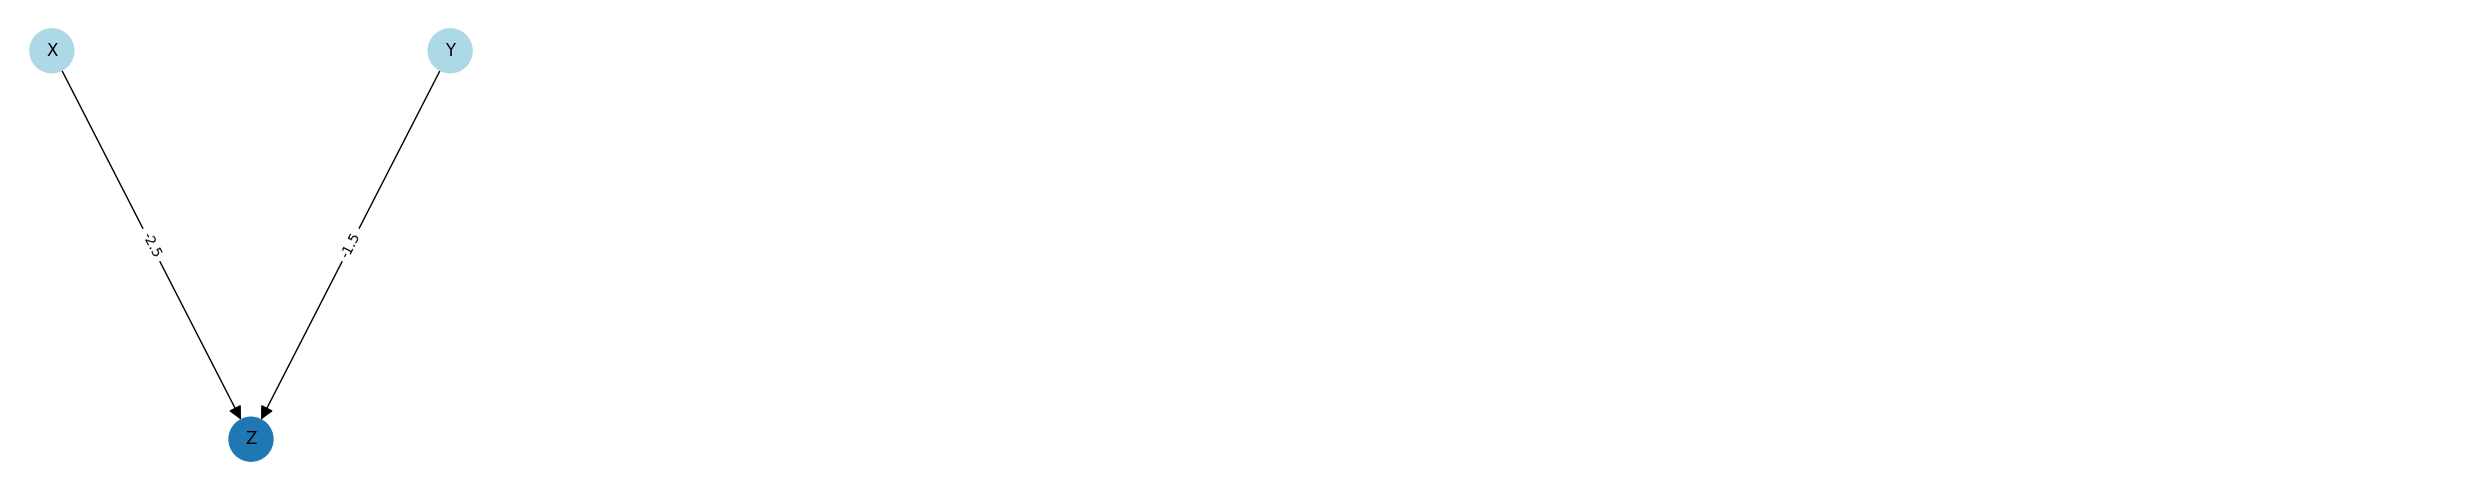

,X,Y,Z
0,8.487313,10.219946,-38.677357
1,8.885226,11.435675,-37.916602
2,7.218455,9.039159,-31.122811
3,10.101191,10.593135,-41.230313
4,8.662779,6.918609,-31.667665
...,...,...,...
995,13.253400,9.033513,-47.770713
996,9.544631,9.916395,-35.870885
997,8.770175,8.964361,-35.349712
998,7.213374,8.788362,-33.487364


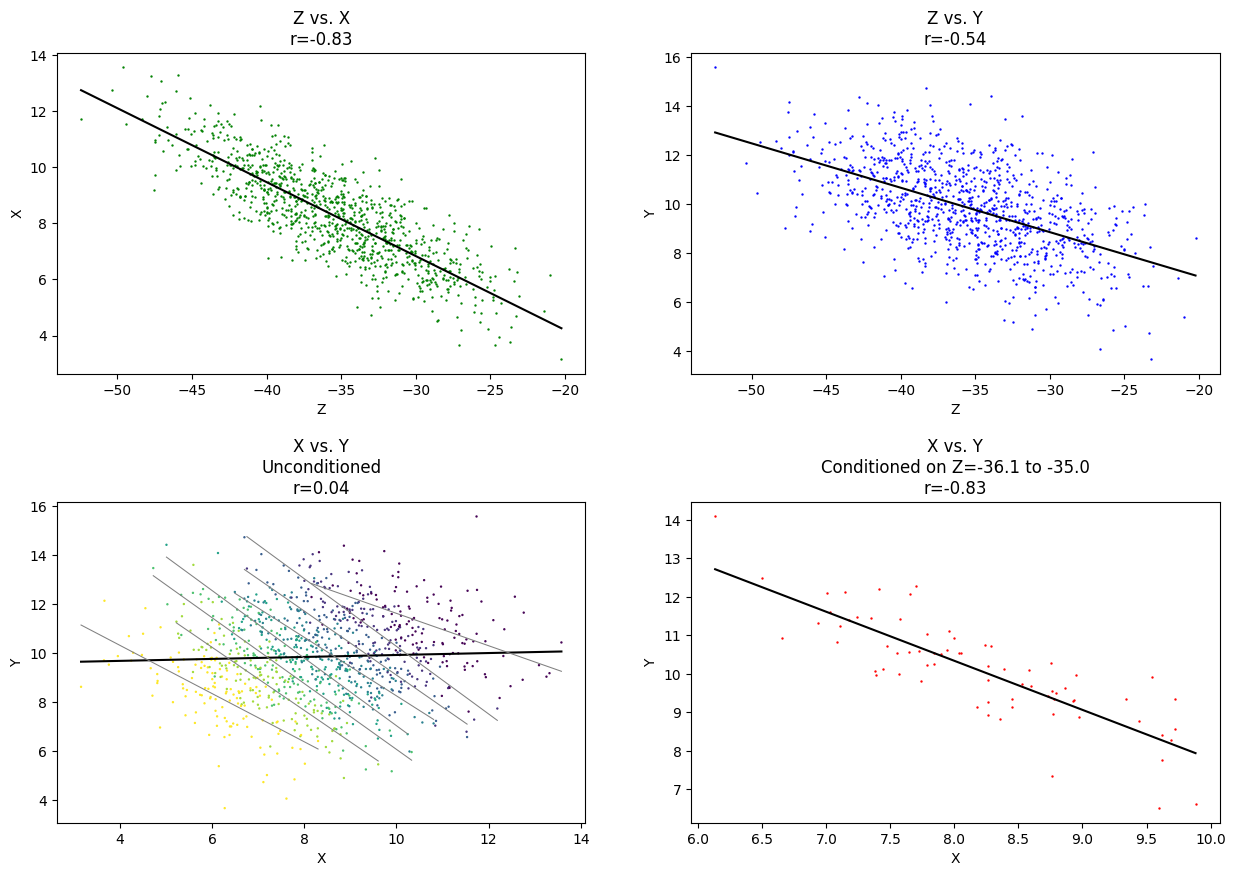

ic| expression: 'Y ⫫̸ X | Z'


-1.3737110474508434

In [45]:
collider_causal_model = create_display_model("simple_collider", display_results=True)

is_dependent_on_conditioned, _, ols_results = collider_causal_model.data.dependence(expression="Y ⫫̸ X | Z")

ols_change = ols_results.params["X"]
ols_change

In [48]:
total = 0
X_mult = 2.5
divisor = -1.5
for index, row in collider_causal_model.data.iterrows():

    total+= (row["Z"] + (X_mult * row["X"])) / divisor
    
print(total / len(collider_causal_model.data))

9.862658853290066


In [44]:
np.mean(np.array(Ys))

9.798534031453105

In [31]:
is_dependent_on_conditioned

True

In [33]:
collider_causal_model.dag.edges

[('X', 'Z'), ('Y', 'Z')]

In [35]:
collider_causal_model.data["Z"].min()

-25.83140726702608

In [36]:
collider_causal_model.data["Z"].max()

16.81658121627837

In [37]:
collider_causal_model.data["Z"].mean()

-4.92324482482755

In [ ]:
# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

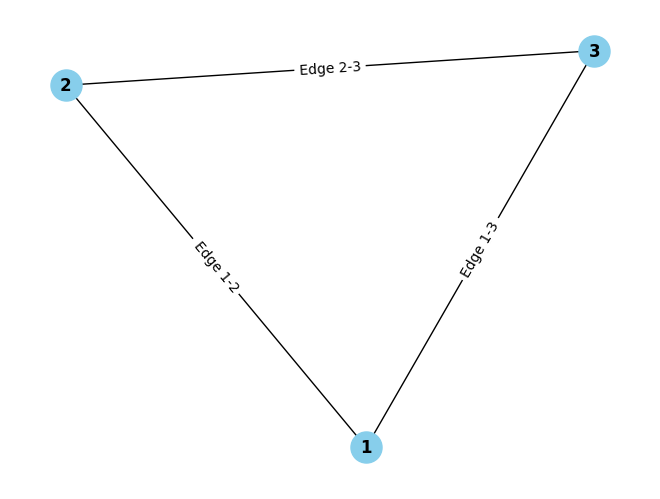

In [25]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()

# Add nodes
G.add_node(1)
G.add_node(2)
G.add_node(3)

# Add edges with labels
G.add_edge(1, 2, label='Edge 1-2')
G.add_edge(2, 3, label='Edge 2-3')
G.add_edge(1, 3, label='Edge 1-3')

# Plotting the graph
pos = nx.spring_layout(G)  # Layout for the nodes

# Draw nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_weight='bold')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()

In [26]:
G.nodes

NodeView((1, 2, 3))

In [27]:
G.edges

EdgeView([(1, 2), (1, 3), (2, 3)])

In [28]:
dag._digraph.edges

OutEdgeView([('W', 'Y'), ('X', 'W'), ('Z1', 'X'), ('Z1', 'Z3'), ('Z3', 'X'), ('Z3', 'Y'), ('Z2', 'Y'), ('Z2', 'Z3')])

In [29]:
edge_labels

{(1, 2): 'Edge 1-2', (1, 3): 'Edge 1-3', (2, 3): 'Edge 2-3'}

In [30]:
# Add draw_labels to DAG
# Call dag draw_labels in causal model and pass in edge_weightings (convert number to string and minimise decimal place)

In [31]:
x = 1.0
print(f"{x:g}")

1
